In [52]:
import pandas as pd
import statistics
import datetime 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")


In [21]:
# import data #
df_fund = pd.read_csv("/content/svm_label.csv") 
df_fund = df_fund[['Date','淨值(元)','BuyOrNot']]
df_fund = df_fund.sort_values('Date')
df_fund = df_fund.reset_index(drop=True)
df_fund

,Date,淨值(元),BuyOrNot
0,2009-02-09,7.80,0
1,2009-02-10,7.62,0
2,2009-02-11,7.65,1
3,2009-02-12,7.58,0
4,2009-02-13,7.63,1
...,...,...,...
2761,2020-05-19,29.16,0
2762,2020-05-20,29.60,0
2763,2020-05-21,29.39,0
2764,2020-05-22,29.43,0


In [34]:
# 因子及變數設定
monthly_money = 6000 # 每月定期定額扣款金額(元)
multiple = 0.9 #之後搭配其他因子調整倍數，用來做加碼閥值設定

df_fund['Date'] = pd.to_datetime(df_fund['Date'])


def sell_return(today_nv, buy_nv, today_date, buy_date): # 計算賣出報酬率
    hold_days = (today_date - buy_date).days
    ret = (today_nv - buy_nv)/ buy_nv
    y_ret = ret/hold_days*365 # 年化報酬率
    return y_ret

def check_no_buy(lis):

  for i in range(len(lis)):
      if lis[i] == 1:
        return False
  return True

In [24]:
# 單純定期定額，不加碼
df_fixed = pd.DataFrame(columns = ["買進日","買入價格","部位淨值","加碼"]) # 存回測結果
start_index = 0 # 測試不同時間開始的報酬率
unit =  monthly_money/df_fund.loc[start_index,'淨值(元)']  # 持有單位,假設從start_index對應的那天開始定期定額
buy_nv = monthly_money # 持有成本

df_fixed = df_fixed.append({"買進日":df_fund.loc[start_index,'Date'],
                                      "買入價格" : df_fund.loc[start_index,'淨值(元)'],
                                      "部位淨值" : buy_nv, 
                                      "加碼": "x"}, ignore_index=True)

for i,item in df_fund.iterrows():
    if((item['Date']-df_fund.loc[start_index,'Date']).days >= 30): # 每"月"定期定額
        unit += monthly_money / item['淨值(元)'] 
        buy_nv = buy_nv + monthly_money
        start_index = i
        df_fixed = df_fixed.append({"買進日": item['Date'], 
                                              "買入價格" : item['淨值(元)'], 
                                              "部位淨值" : unit*item['淨值(元)'],
                                              "加碼": "x"}, ignore_index=True)

print("end loop")
print(unit*df_fund.loc[len(df_fund)-1,'淨值(元)'])
print(buy_nv)
profit_ret = sell_return(unit*df_fund.loc[len(df_fund)-1,'淨值(元)'], buy_nv,
                         df_fund.loc[len(df_fund)-1,'Date'], df_fixed.loc[0,'買進日'])
print(profit_ret*100 ,"%")   
#pd.set_option('display.max_rows', None)
df_fixed

end loop
1304978.833896547
810000
5.408487336166484 %


,買進日,買入價格,部位淨值,加碼
0,2009-02-09,7.80,6000,x
1,2009-03-11,7.20,11538.5,x
2,2009-04-10,8.36,19397.4,x
3,2009-05-11,9.45,27926.5,x
4,2009-06-10,10.16,36024.7,x
...,...,...,...,...
130,2019-12-23,29.91,1.28724e+06,x
131,2020-01-30,30.09,1.30098e+06,x
132,2020-03-02,28.52,1.2391e+06,x
133,2020-04-01,24.58,1.07392e+06,x


In [45]:
#低檔投資法回測 ：10% 加碼, 淨值若比10天前下跌10%,「隔天」就加碼
df_10_percent = pd.DataFrame(columns = ["買進日","買入價格","部位淨值","加碼"]) # 存回測結果
start_index = 0 # 測試不同時間開始的報酬率
unit =  monthly_money/df_fund.loc[start_index,'淨值(元)']  # 持有單位,假設從start_index對應的那天開始定期定額
buy_nv = monthly_money # 持有成本

df_10_percent = df_10_percent.append({"買進日":df_fund.loc[start_index,'Date'],
                                      "買入價格" : df_fund.loc[start_index,'淨值(元)'],
                                      "部位淨值" : buy_nv,
                                      "目前報酬率": 0, 
                                      "加碼": "x"}, ignore_index=True)

for i,item in df_fund.iterrows():
    if((item['Date']-df_fund.loc[start_index,'Date']).days >= 30): # 每"月"定期定額
        unit += monthly_money / item['淨值(元)'] 
        buy_nv = buy_nv + monthly_money
        start_index = i
        df_10_percent = df_10_percent.append({"買進日": item['Date'], 
                                              "買入價格" : item['淨值(元)'], 
                                              "部位淨值" : unit*item['淨值(元)'],
                                              "目前報酬率":  sell_return(unit*df_fund.loc[i,'淨值(元)'], buy_nv,
                                                                        df_fund.loc[i,'Date'], df_10_percent.loc[0,'買進日']),
                                              "加碼": "x"}, ignore_index=True)
    
    if(i>=10):
        if( item['淨值(元)'] <= 0.9*(df_fund.loc[i-10,'淨值(元)']) ): # 加碼
            buy_date = df_fund.loc[i+1,'Date']
            unit += monthly_money / item['淨值(元)'] 
            buy_nv = buy_nv + monthly_money
            df_10_percent = df_10_percent.append({"買進日":buy_date, 
                                                  "買入價格" : df_fund.loc[i+1,'淨值(元)'], 
                                                  "部位淨值" : unit*item['淨值(元)'],
                                                  "目前報酬率":  sell_return(unit*df_fund.loc[i,'淨值(元)'], buy_nv,
                                                                        df_fund.loc[i,'Date'], df_10_percent.loc[0,'買進日']),
                                                  "加碼": "v"}, ignore_index=True)
print("end loop")
print(unit*df_fund.loc[len(df_fund)-1,'淨值(元)'])
print(buy_nv)
profit_ret = sell_return(unit*df_fund.loc[len(df_fund)-1,'淨值(元)'], buy_nv,
                         df_fund.loc[len(df_fund)-1,'Date'], df_10_percent.loc[0,'買進日'])
print(profit_ret*100 ,"%")   
#pd.set_option('display.max_rows', None)
df_10_percent

end loop
1539024.6094826525
960000
5.338263378525303 %


,買進日,買入價格,部位淨值,加碼,目前報酬率
0,2009-02-09,7.80,6000,x,0.000000
1,2009-03-11,7.20,11538.5,x,-0.467949
2,2009-04-10,8.36,19397.4,x,0.472282
3,2009-05-11,9.45,27926.5,x,0.656219
4,2009-06-10,10.16,36024.7,x,0.605790
5,2009-07-10,9.28,38904.5,x,0.195020
6,2009-08-10,11.30,53372.9,x,0.543054
7,2009-09-09,11.90,62206.8,x,0.509581
8,2009-10-09,12.45,71082,x,0.477113
9,2009-11-09,12.80,79080.2,x,0.425170


In [118]:
d1 = df_10_percent.groupby('加碼').get_group('v')
print(len(d1))
d1

25


,買進日,買入價格,部位淨值,加碼,目前報酬率
15,2010-05-10,13.50,114809,v,0.158218
31,2011-08-08,15.41,246843,v,0.114950
32,2011-08-09,15.75,239222,v,0.083506
33,2011-08-10,15.46,250500,v,0.091327
35,2011-08-11,15.85,257888,v,0.077613
36,2011-08-12,16.09,270393,v,0.087148
37,2011-08-15,16.17,280488,v,0.091933
39,2011-10-03,13.67,258436,v,0.029116
40,2011-10-04,13.51,255493,v,0.014581
41,2011-10-05,13.91,258503,v,0.009740


In [68]:
# SVM 投資法回測 ：模型釋出 BUY 的訊號就在隔天加碼
df_svm = pd.DataFrame(columns = ["買進日","買入價格","部位淨值","加碼"]) # 存回測結果
start_index = 0 # 測試不同時間開始的報酬率
unit =  monthly_money/df_fund.loc[start_index,'淨值(元)']  # 持有單位,假設從start_index對應的那天開始定期定額
buy_nv = monthly_money # 持有成本
signal_list = df_fund['BuyOrNot'].tolist()

df_svm = df_svm.append({"買進日":df_fund.loc[start_index,'Date'],
                                      "買入價格" : df_fund.loc[start_index,'淨值(元)'],
                                      "部位淨值" : buy_nv,
                                      "目前報酬率":  0,
                                      "加碼": "x"}, ignore_index=True)

for i,item in df_fund.iterrows():
    if((item['Date']-df_fund.loc[start_index,'Date']).days >= 30): # 每"月"定期定額
        unit += monthly_money / item['淨值(元)'] 
        buy_nv = buy_nv + monthly_money
        start_index = i
        
        df_svm = df_svm.append({"買進日": item['Date'], 
                                              "買入價格" : item['淨值(元)'], 
                                              "部位淨值" : unit*item['淨值(元)'],
                                              "目前報酬率":  sell_return(unit*df_fund.loc[i,'淨值(元)'], buy_nv,
                                                                        df_fund.loc[i,'Date'], df_svm.loc[0,'買進日']),
                                              "加碼": "x"}, ignore_index=True)
    
    if(i>=10):
        if( item['BuyOrNot'] == 1 and item['淨值(元)'] <= 0.9*(df_fund.loc[i-10,'淨值(元)']) ): # 加碼

          buy_date = df_fund.loc[i+1,'Date']
          unit += monthly_money / item['淨值(元)'] 
          buy_nv = buy_nv + monthly_money
          df_svm = df_svm.append({"買進日":buy_date, 
                                  "買入價格" : df_fund.loc[i+1,'淨值(元)'], 
                                  "部位淨值" : unit*item['淨值(元)'],
                                  "目前報酬率":  sell_return(unit*df_fund.loc[i,'淨值(元)'], buy_nv,
                                                                  df_fund.loc[i,'Date'], df_svm.loc[0,'買進日']),
                                  "加碼": "v"}, ignore_index=True)
print("end loop")
print(unit*df_fund.loc[len(df_fund)-1,'淨值(元)'])
print(buy_nv)
profit_ret = sell_return(unit*df_fund.loc[len(df_fund)-1,'淨值(元)'], buy_nv,
                         df_fund.loc[len(df_fund)-1,'Date'], df_svm.loc[0,'買進日'])
print(profit_ret*100 ,"%")   
#pd.set_option('display.max_rows', None)
df_svm

end loop
1503326.4713501371
930000
5.4562373424590405 %


,買進日,買入價格,部位淨值,加碼,目前報酬率
0,2009-02-09,7.80,6000,x,0.000000
1,2009-03-11,7.20,11538.5,x,-0.467949
2,2009-04-10,8.36,19397.4,x,0.472282
3,2009-05-11,9.45,27926.5,x,0.656219
4,2009-06-10,10.16,36024.7,x,0.605790
5,2009-07-10,9.28,38904.5,x,0.195020
6,2009-08-10,11.30,53372.9,x,0.543054
7,2009-09-09,11.90,62206.8,x,0.509581
8,2009-10-09,12.45,71082,x,0.477113
9,2009-11-09,12.80,79080.2,x,0.425170


In [94]:
d2 = df_svm.groupby('加碼').get_group('x')
print(len(d2))
pd.set_option('display.max_rows', None)
d2

20


,買進日,買入價格,部位淨值,加碼,目前報酬率
15,2010-05-10,13.50,114809,v,0.158218
31,2011-08-08,15.41,246843,v,0.114950
32,2011-08-09,15.75,239222,v,0.083506
33,2011-08-10,15.46,250500,v,0.091327
35,2011-08-11,15.85,257888,v,0.077613
36,2011-08-12,16.09,270393,v,0.087148
37,2011-08-15,16.17,280488,v,0.091933
39,2011-10-03,13.67,258436,v,0.029116
40,2011-10-04,13.51,255493,v,0.014581
41,2011-10-05,13.91,258503,v,0.009740


In [122]:
l1 = d1['買進日'].tolist()
l2 = d2['買進日'].tolist()

for ll in l1:
  if ll not in l2:
    print(ll)

2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-12 00:00:00
2020-03-17 00:00:00
2020-03-23 00:00:00


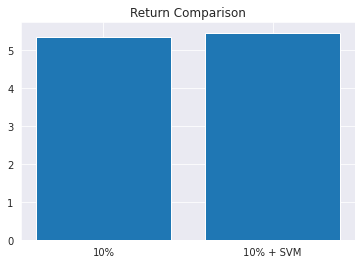

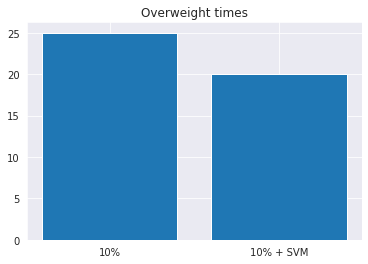

In [93]:
# 報酬率 買進次數 圖 5.4085,
return_list = [5.3383, 5.4562]
buy_count = [25,20]
x = ['10%','10% + SVM']
x2 = ['10%','10% + SVM']
plt.bar(x,return_list)
plt.title('Return Comparison')
plt.show()
plt.title('Overweight times')
plt.bar(x2,buy_count)
plt.show()


In [119]:
df_merge = df_fund
buy_list = d1['買進日'].tolist()
df_merge['Buy'] = 'x'
for i in range(len(df_merge)):
  if df_merge.loc[i,'Date'] in buy_list:
      df_merge.loc[i,'Buy'] = 'v'

df_merge

,Date,淨值(元),BuyOrNot,Buy
0,2009-02-09,7.80,0,x
1,2009-02-10,7.62,0,x
2,2009-02-11,7.65,1,x
3,2009-02-12,7.58,0,x
4,2009-02-13,7.63,1,x
5,2009-02-16,7.59,1,x
6,2009-02-17,7.42,1,x
7,2009-02-18,7.35,1,x
8,2009-02-19,7.39,1,x
9,2009-02-20,7.26,1,x


In [120]:
a = df_merge.groupby('Buy').get_group('v')
a.index

Int64Index([ 314,  626,  627,  628,  629,  630,  631,  665,  666,  667,  668,
            2391, 2709, 2713, 2714, 2715, 2717, 2718, 2719, 2720, 2721, 2722,
            2723, 2724, 2725],
           dtype='int64')

No handles with labels found to put in legend.


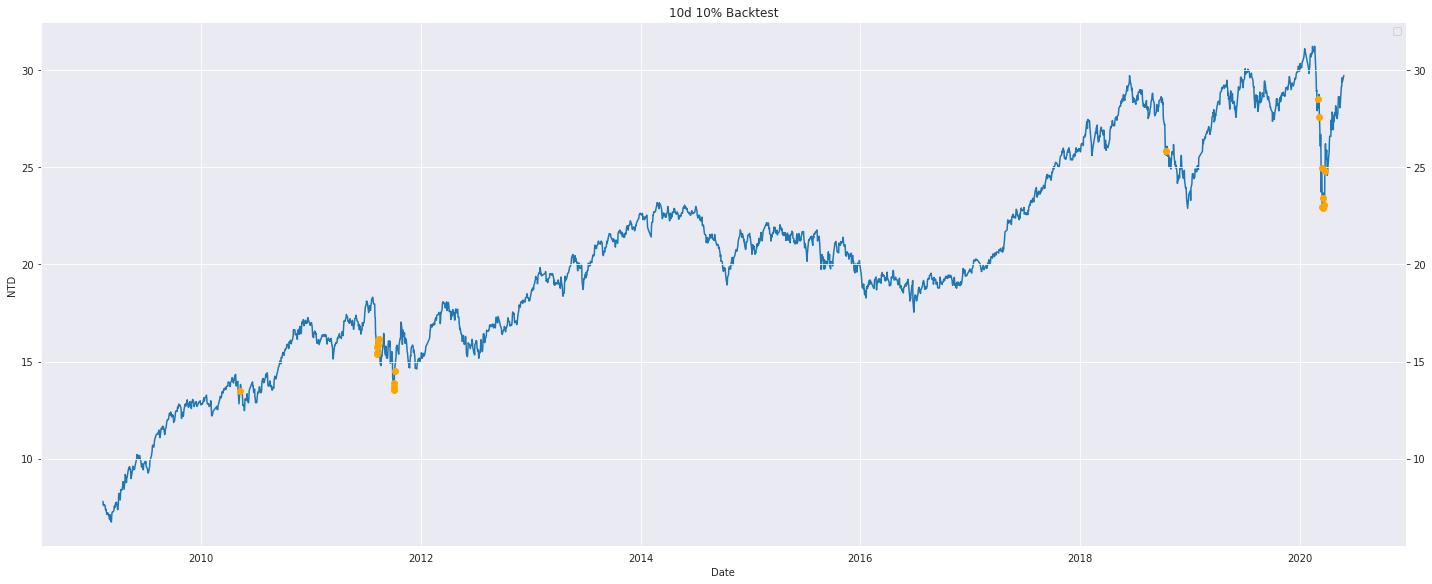

In [124]:
df_back = pd.DataFrame(columns=['Date','NV','Add Buy'])
df_back['Date'] = df_fund['Date']
df_back['NV'] = df_merge['淨值(元)']
df_back['Add Buy'] = df_merge['Buy']

fig, ax1 = plt.subplots()
fig.set_size_inches(20, 8)

plt.xlabel('Date')
ax2 = ax1.twinx()

ax1.set_ylabel('NTD')
ax1.plot(df_back['Date'],df_back['NV'])
ax1.tick_params(axis='y')


ax2.scatter(d2['買進日'],d2['買入價格'], color='orange')
ax2.tick_params(axis='y')
ax2.set_ylim(ax1.get_ylim())

plt.legend()
fig.tight_layout() 
plt.title('10d 10% Backtest')
plt.show()

ValueError: ignored

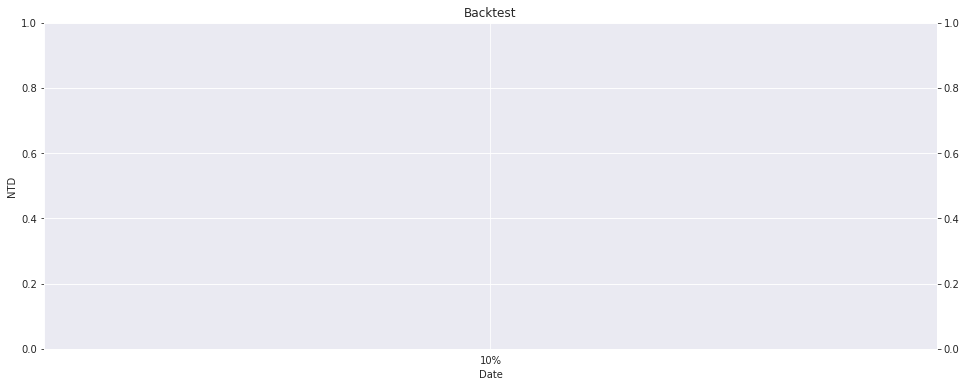

In [97]:
x1 = df_fund['Date'].tolist()
y1 = df_fund['淨值(元)'].tolist()

x1 = d2['買進日'].tolist()
y2 = d2['買入價格'].tolist()

fig, ax1 = plt.subplots()
fig.set_size_inches(16, 6)
plt.title('Backtest')
plt.xlabel('Date')
ax2 = ax1.twinx()

ax1.set_ylabel('NTD')
ax1.plot(x, y1)
ax1.tick_params(axis='y')

ax2.plot(x, y2, color='orange')
ax2.tick_params(axis='y')

plt.legend()
fig.tight_layout() 
plt.show()